In [4]:
import urllib.request
import zipfile, os
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tiktoken



## 1 Download Dataset

In [5]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download ""and extraction.")
    
    return
with urllib.request.urlopen(url) as response: 
   with open(zip_path, "wb") as out_file:
      out_file.write(response.read())
 
with zipfile.ZipFile(zip_path, "r") as zip_ref: 
   zip_ref.extractall(extracted_path)

original_file_path = Path(extracted_path) / "SMSSpamCollection"
os.rename(original_file_path, data_file_path) 
print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection\SMSSpamCollection.tsv
sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [6]:
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

print(df["Label"].value_counts()) # Show that it is an inbalanced dataset
df.head()

Label
ham     4825
spam     747
Name: count, dtype: int64


,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:

# Create a balanced dataset using scikit-learn resample

def create_balanced_dataset(df):
    ham_class_df = df[df['Label'] == 'ham'] # Mayor class
    spam_class_df = df[df['Label'] == 'spam'] # Minor class

    # Resamplear la clase mayor
    ham_class_df_resampled = resample(ham_class_df,
                                    replace=False,    # No replacement
                                    n_samples=len(spam_class_df),    # number of samples equal to minor class
                                    random_state=42)   # for reproductibility

    # Unir los datasets
    df_balanced = pd.concat([spam_class_df, ham_class_df_resampled])

    # Opcional: Barajar el dataset
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    df_balanced["Label"] = df_balanced["Label"].map({"ham": 0, "spam": 1})
    return df_balanced

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())    

Label
0    747
1    747
Name: count, dtype: int64


In [8]:
# Create the train, validation and test sets, 70%, 10%, 20%

train_df, temp_df = train_test_split(balanced_df, test_size=0.3, random_state=42)
validation_df, test_df = train_test_split(temp_df, test_size=0.2, random_state=42)

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)
train_df.head()

,Label,Text
500,0,Do you know where my lab goggles went
737,0,"My planning usually stops at ""find hella weed,..."
486,1,Call 09095350301 and send our girls into eroti...
493,0,Yar lor... Keep raining non stop... Or u wan 2...
10,0,K still are you loving me.


In [9]:
# Create DataLoaders

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length = None, pad_token_id = 50256):

        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]
        
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequence if they are longer than max_length
            self.encoded_texts = [encoded_text[:self.max_length] for encoded_text in self.encoded_texts]
        # Pads sequences to longest sequence
        self.encoded_texts = [encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts]
    
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]['Label']

        return (
            torch.tensor(encoded, dtype = torch.long),
            torch.tensor(label, dtype = torch.long)
                )
    
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_length = 0

        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


In [10]:
tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

137


In [11]:
# Launch DataLoaders

num_workers = 0 # leave at zero
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)
print('')
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

Input batch dimensions: torch.Size([8, 137])
Label batch dimensions torch.Size([8])

130 training batches
45 validation batches
12 test batches


In [12]:
# Initialize with pre-trained weights
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [13]:

from GPT2Model import GPTModel
from GPT2Model import text_to_token_ids, token_ids_to_text, generate_text_simple
from safetensors.torch import load

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "model.safetensors"
with open(file_path, "rb") as f:
    data = f.read()

loaded_gpt = load(data)
model = GPTModel(BASE_CONFIG)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (Wq): Linear(in_features=768, out_features=768, bias=True)
        (Wk): Linear(in_features=768, out_features=768, bias=True)
        (Wv): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (Wq): Linear(in_features=768, out_features=7

In [14]:

def assign_check(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(right.clone().detach())

def load_weights(gpt, gpt_hf, BASE_CONFIG):

    #d = gpt_hf.state_dict()
    d = gpt_hf # If we load the model.safetensors is loaded already as a dict
    
    gpt.pos_emb.weight = assign_check(gpt.pos_emb.weight, d["wpe.weight"])
    gpt.tok_emb.weight = assign_check(gpt.tok_emb.weight, d["wte.weight"])
    
    for b in range(BASE_CONFIG["n_layers"]):
        q_w, k_w, v_w = np.split(d[f"h.{b}.attn.c_attn.weight"], 3, axis=-1)
        gpt.trf_blocks[b].att.Wq.weight = assign_check(gpt.trf_blocks[b].att.Wq.weight, q_w.T)
        gpt.trf_blocks[b].att.Wk.weight = assign_check(gpt.trf_blocks[b].att.Wk.weight, k_w.T)
        gpt.trf_blocks[b].att.Wv.weight = assign_check(gpt.trf_blocks[b].att.Wv.weight, v_w.T)
    
        q_b, k_b, v_b = np.split(d[f"h.{b}.attn.c_attn.bias"], 3, axis=-1)
        gpt.trf_blocks[b].att.Wq.bias = assign_check(gpt.trf_blocks[b].att.Wq.bias, q_b)
        gpt.trf_blocks[b].att.Wk.bias = assign_check(gpt.trf_blocks[b].att.Wk.bias, k_b)
        gpt.trf_blocks[b].att.Wv.bias = assign_check(gpt.trf_blocks[b].att.Wv.bias, v_b)
    
    
        gpt.trf_blocks[b].att.out_proj.weight = assign_check(gpt.trf_blocks[b].att.out_proj.weight, d[f"h.{b}.attn.c_proj.weight"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign_check(gpt.trf_blocks[b].att.out_proj.bias, d[f"h.{b}.attn.c_proj.bias"])
    
        gpt.trf_blocks[b].ff.layers[0].weight = assign_check(gpt.trf_blocks[b].ff.layers[0].weight, d[f"h.{b}.mlp.c_fc.weight"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign_check(gpt.trf_blocks[b].ff.layers[0].bias, d[f"h.{b}.mlp.c_fc.bias"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign_check(gpt.trf_blocks[b].ff.layers[2].weight, d[f"h.{b}.mlp.c_proj.weight"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign_check(gpt.trf_blocks[b].ff.layers[2].bias, d[f"h.{b}.mlp.c_proj.bias"])
    
        gpt.trf_blocks[b].norm1.scale = assign_check(gpt.trf_blocks[b].norm1.scale, d[f"h.{b}.ln_1.weight"])
        gpt.trf_blocks[b].norm1.shift = assign_check(gpt.trf_blocks[b].norm1.shift, d[f"h.{b}.ln_1.bias"])
        gpt.trf_blocks[b].norm2.scale = assign_check(gpt.trf_blocks[b].norm2.scale, d[f"h.{b}.ln_2.weight"])
        gpt.trf_blocks[b].norm2.shift = assign_check(gpt.trf_blocks[b].norm2.shift, d[f"h.{b}.ln_2.bias"])
    
        gpt.final_norm.scale = assign_check(gpt.final_norm.scale, d[f"ln_f.weight"])
        gpt.final_norm.shift = assign_check(gpt.final_norm.shift, d[f"ln_f.bias"])
        gpt.out_head.weight = assign_check(gpt.out_head.weight, d["wte.weight"])

    return gpt

In [15]:

model = load_weights(model, loaded_gpt,BASE_CONFIG)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (Wq): Linear(in_features=768, out_features=768, bias=True)
        (Wk): Linear(in_features=768, out_features=768, bias=True)
        (Wv): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (Wq): Linear(in_features=768, out_features=7

In [16]:
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(text_1, tokenizer),
    max_new_tokens = 15,
    context_size = BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [17]:
text_2 = (
"Is the following text 'spam'? Answer with 'yes' or 'no':"
" 'You are a winner you have been specially"
" selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [18]:
# Add classification head

for param in model.parameters():
    param.requires_grad = False

torch.manual_seed(123)
num_classes = 2

model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

# Train the layer norm and the last transformer block
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [19]:
# Calculating loss and accuracy

def calc_accuracy_loader(data_loader, model, device,num_batches = None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]

            predicted_labels = torch.argmax(logits, dim = -1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    
    return correct_predictions / num_examples

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 55.00%
Validation accuracy: 55.00%
Test accuracy: 48.75%


In [22]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:, -1, :] 
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else: 
        num_batches = min(num_batches, len(data_loader))
        
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [23]:
with torch.no_grad(): 
 train_loss = calc_loss_loader(
 train_loader, model, device, num_batches=5
 )
 val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
 test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.701
Validation loss: 2.446
Test loss: 2.707


In [25]:
# Fine tunning on supervised data

def train_classifier_simple(
        model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter
        ):
    
    train_losses, val_losses, train_accs, val_accs = [], [],[],[]
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(F"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                      )
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    return train_losses, val_losses, train_accs, val_accs, examples_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [26]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = \
 train_classifier_simple(
 model, train_loader, val_loader, optimizer, device,
 num_epochs=num_epochs, eval_freq=50,
 eval_iter=5
 )
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.865, Val loss 2.262
Ep 1 (Step 000050): Train loss 0.631, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.504, Val loss 0.568
Training accuracy: 87.50% | Validation accuracy: 80.00%
Ep 2 (Step 000150): Train loss 0.501, Val loss 0.553
Ep 2 (Step 000200): Train loss 0.352, Val loss 0.426
Ep 2 (Step 000250): Train loss 0.556, Val loss 0.423
Training accuracy: 85.00% | Validation accuracy: 87.50%
Ep 3 (Step 000300): Train loss 0.413, Val loss 0.406
Ep 3 (Step 000350): Train loss 0.284, Val loss 0.347
Training accuracy: 87.50% | Validation accuracy: 87.50%
Ep 4 (Step 000400): Train loss 0.303, Val loss 0.296
Ep 4 (Step 000450): Train loss 0.068, Val loss 0.210
Ep 4 (Step 000500): Train loss 0.020, Val loss 0.180
Training accuracy: 95.00% | Validation accuracy: 90.00%
Ep 5 (Step 000550): Train loss 0.017, Val loss 0.150
Ep 5 (Step 000600): Train loss 0.087, Val loss 0.159
Training accuracy: 97.50% | Validation accuracy: 95.00%
Training completed in 16.81 min

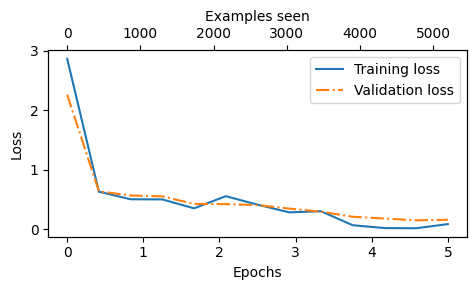

In [27]:
import matplotlib.pyplot as plt
def plot_values(
    epochs_seen, examples_seen, train_values, val_values,
    label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
    epochs_seen, val_values, linestyle="-.",
    label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0) 
    ax2.set_xlabel("Examples seen")
    fig.tight_layout() 
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

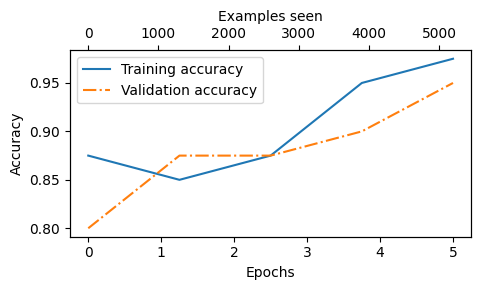

In [28]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(
 epochs_tensor, examples_seen_tensor, train_accs, val_accs,
 label="accuracy"
)

In [29]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.69%
Validation accuracy: 96.38%
Test accuracy: 96.67%


In [30]:
def classify_review(
    text, model, tokenizer, device, max_length=None,
    pad_token_id=50256):
    model.eval()
    input_ids = tokenizer.encode(text) 
    supported_context_length = model.pos_emb.weight.shape[1]
    input_ids = input_ids[:min( 
    max_length, supported_context_length
    )]
    input_ids += [pad_token_id] * (max_length - len(input_ids)) 

    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) 

    with torch.no_grad(): 
        logits = model(input_tensor)[:, -1, :] 
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

In [31]:
text_1 = (
 "You are a winner you have been specially"
 " selected to receive $1000 cash or a $2000 award."
)
print(classify_review(
 text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [32]:
torch.save(model.state_dict(), "review_classifier.pth")